<h1> MBA Zero Byte and UDP Loss Analysis (June 2021, Raw) </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

In [1]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [57]:
%%toggle_code
import os
import pandoc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline


print('Executed')

In [3]:
def dfNormalizer(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    total_boxes = df['total_boxes']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty, total_boxes=total_boxes))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

In [4]:
def removeTiersWithLimitedResults(df, limNum):
    df = df
    series= df['ispTech'].value_counts()
    limNum = limNum
    outList = []
    i = 0
    
    while i < len(series):
        for count in series:
            if count != limNum:
                outList.append(series.index[i])
            i+=1
            
    outDF = df[~df['ispTech'].isin(outList)]

    return outDF

In [5]:
x = 0
def time2int(junZeroByteDF):
    for time in junZeroByteDF['testDtime']:
        junZeroByteDF['dTimeInt'] = time.value
    return junZeroByteDF
    
    
   

<h3> Raw MBA June Data

<h4> Download results with concurrent TCP connections June 2021 (Raw)

In [6]:
raw_download_jun2021 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2021` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2021` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_jun2021 = client.query(raw_download_jun2021).to_dataframe()
print("executed")
print("raw dataset from June 2021")


executed
raw dataset from June 2021


<h4> Zero byte speed results June 2021 (Raw)

In [7]:
junZeroByteSQL = """
SELECT
  mt.Unit_ID as unitID,
  mt.download as downloadTier,
  mt.ISP as ISP,
  mt.Technology as tech,
  httpmt.bytes_sec as bytesSec,
  httpmt.dtime as testDtime,
  
FROM
  `broadband-data.mba_data.curr_httpgetmtJun21` as httpmt
INNER JOIN
  `broadband-data.mba_data.unit-profile-sept2021` as mt ON httpmt.unit_id=mt.Unit_ID
WHERE (httpmt.bytes_sec = 0)
GROUP BY unitID, downloadTier, ISP, tech,  bytesSec, testDtime
ORDER BY mt.Download
"""
junZeroByteDF = client.query(junZeroByteSQL).to_dataframe()
print("executed")
print("Zero byte June 2021 table")


executed
Zero byte June 2021 table


<h4> UDP Loss June 2021 (Raw)

In [8]:
udpcLossSQLJUN2021 = """
SELECT 
    count(*) as totalOutages, 
    mt.ISP as ISP, 
    mt.Technology as tech, 
    mt.Download as DownloadTier, 
    SUM(udploss.duration/1000) as totalOutageDuration,
    AVG(udploss.duration/1000) as avgOutageMs, 
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMs,
    SUM(udploss.packets) as totalPacketLoss,
    AVG(udploss.packets) as avgPacketLoss, 
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
    COUNT(DISTINCT mt.unit_id) as total_boxes,
FROM `broadband-data.mba_data.curr_udpclossRawJun2021` as udploss 
    INNER JOIN `broadband-data.mba_data.unit-profile-sept2021` as mt ON udploss.unit_id=mt.Unit_ID
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING COUNT(DISTINCT mt.unit_id) > 29
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""
rawJun21UDPCLoss = client.query(udpcLossSQLJUN2021).to_dataframe()
print("executed")
print("UDPC Loss June 2021 table")

executed
UDPC Loss June 2021 table


<h4> Select tier UDP loss SQL Query June 2021 (Raw)

In [9]:
udpLossAllSQLJun21 = """
SELECT 
    mt.Unit_ID as unitID,
    mt.ISP as isp, 
    mt.Technology as tech, 
    mt.Download as tier, 
    (udploss.duration/1000) as durationMs, 
    udploss.packets as packetsLost,
    udploss.dtime as testDtime,
FROM `broadband-data.mba_data.curr_udpclossRawJun2021` as udploss 
INNER JOIN `broadband-data.mba_data.unit-profile-sept2021` as mt ON udploss.unit_id=mt.Unit_ID
GROUP BY unitID, isp, tech, tier, durationMs, packetsLost,testDtime
ORDER BY  testDtime
"""
udpLossAllJun21 = client.query(udpLossAllSQLJun21).to_dataframe()
print("executed")
print("UDPC Loss All test Results June 2021")

executed
UDPC Loss All test Results June 2021


<h3> Preprocessing

In [11]:
# creating dataframes for analysis on Charter and Comcast 400 cable tier
charter400UDPLossJun21 = udpLossAllJun21[(udpLossAllJun21['isp'] == "Charter") & (udpLossAllJun21['tier'] == 400)]
charter400UDPLossJun21 = charter400UDPLossJun21.groupby(["unitID"]).describe()
comcast400UDPLossJun21 = udpLossAllJun21[(udpLossAllJun21['isp'] == "Comcast") & (udpLossAllJun21['tier'] == 400)]
comcast400UDPLossJun21 = comcast400UDPLossJun21.groupby(["unitID"]).describe()
# charter400UDPLossJun21.head()



In [56]:
# IN PROGRESS
# outages over 30 seconds DF
msToSecs = 1000
udpLossAllJun21['durationSecs'] = udpLossAllJun21['durationMs']/1000

outagesOver30Secs = pd.DataFrame()
outagesOver30Secs = udpLossAllJun21[udpLossAllJun21['durationSecs'] >=30]
# outagesOver30Secs.groupby(["tier", "isp", "tech"], as_index=False).describe()

In [12]:
# cleaning up raw download data
# ONLY RUN ONCE
raw_download_jun2021 = dfNormalizer(raw_download_jun2021)

In [47]:
# combining download data w/ UDP loss data (summary stats)
rawJun21UDPCLoss.rename(columns={'DownloadTier': 'tier', 'ISP':'isp'}, inplace=True)
rawJun21UDPCLoss['month'] = 'Jun2021'
junCols = rawJun21UDPCLoss.columns.difference(raw_download_jun2021.columns)
rawMBAJun21 = pd.merge(raw_download_jun2021, rawJun21UDPCLoss[junCols],left_index=True, 
                      right_index=True, how='outer').dropna()
msToHrs = 3.6e+6
rawMBAJun21['totalOutageDurationSecs'] = rawMBAJun21['totalOutageDuration']/1000
rawMBAJun21['totalOutageDurationHrs'] = rawMBAJun21['totalOutageDuration']/msToHrs
rawMBAJun21['medianOutageSecs'] = rawMBAJun21['medianOutageMs']/1000
rawMBAJun21['avgOutageSecs'] = rawMBAJun21['avgOutageMs']/1000
rawMBAJun21['twentyPctOutageSecs'] = rawMBAJun21['twentyPctOutageMs']/1000
rawMBAJun21['fithPctOutageSecs'] = rawMBAJun21['fifthpctOutageMs']/1000

In [14]:
#cleaning up zero byte summary stat df
junZeroByteDF = junZeroByteDF.rename(columns = {"downloadTier": "tier", "ISP": "isp", "bytesSec":"0ByteResults"})
uniBoxes = junZeroByteDF.groupby(["tier", "isp", 'tech'], as_index=False)["unitID"].nunique()
uniBoxes = uniBoxes['unitID']
junZeroByteGroupDF = junZeroByteDF.groupby(["tier", "isp", "tech"], as_index=False)["0ByteResults"].count()
junZeroByteGroupDF = junZeroByteGroupDF.join(uniBoxes)
junZeroByteGroupDF = junZeroByteGroupDF.rename(columns = {"unitID": "total_boxes"})
mask = junZeroByteGroupDF['total_boxes'] > 29
junZeroByteGroupDF=junZeroByteGroupDF[mask]


In [15]:
# creating special DF to look at 0 byte results
rawMBAJun21w0ByteResults = pd.merge(rawMBAJun21, junZeroByteGroupDF, on=["isp", 'tier','tech'], how="left").dropna()


In [16]:
# combining zero byte results with udp outage results for select tiers
charter400Jun21 = junZeroByteDF[(junZeroByteDF['tier'] == 400) & (junZeroByteDF['isp'] == "Charter")]
charter400Jun21 = charter400Jun21.groupby(["unitID"]).describe()
charter400Jun21 = pd.merge(charter400Jun21, charter400UDPLossJun21, on=["unitID"], how="left").dropna()
comcast400Jun21 = junZeroByteDF[(junZeroByteDF['tier'] == 400) & (junZeroByteDF['isp'] == "Comcast")]
comcast400Jun21 = comcast400Jun21.groupby(["unitID"]).describe()
comcast400Jun21 = pd.merge(comcast400Jun21, comcast400UDPLossJun21, on=["unitID"], how="left").dropna()


<h2> Results and tables

<h3> Zero Byte Download Result Analysis

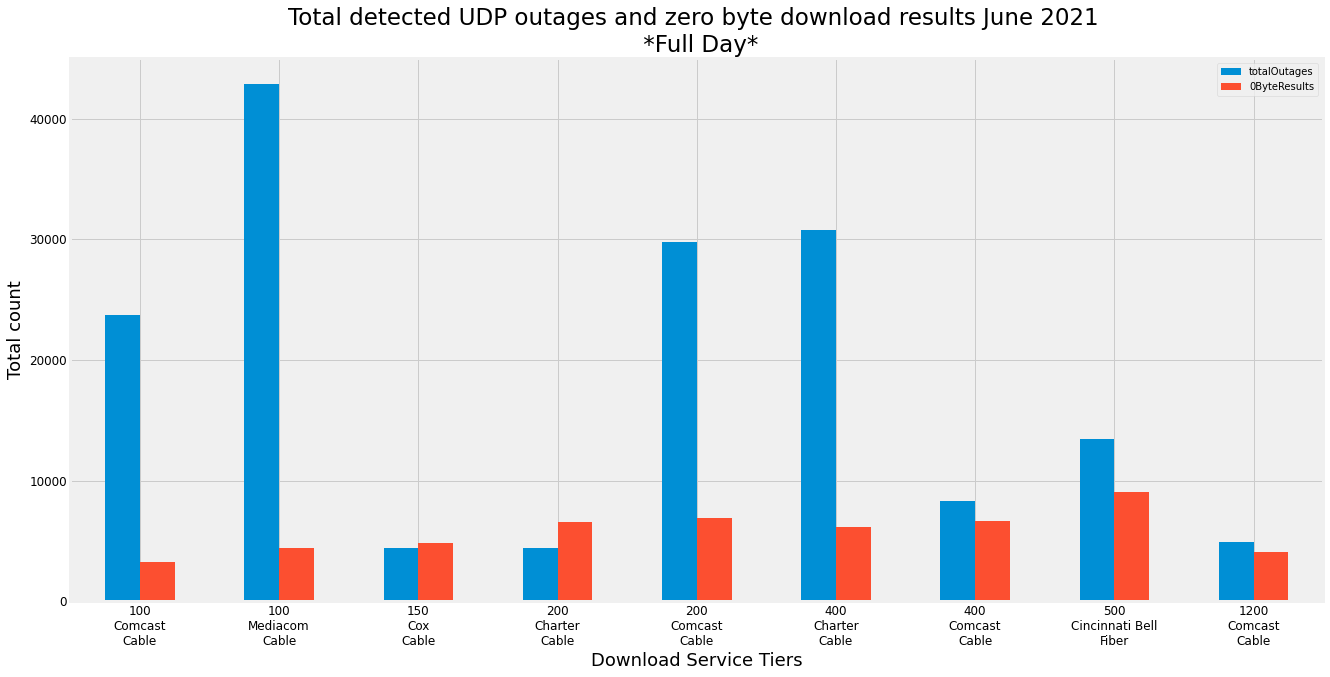

In [17]:
ax = rawMBAJun21w0ByteResults.plot(x = "ispTech", y = [ 'totalOutages', '0ByteResults'],  kind = 'bar', stacked = False, 
                   fontsize = 12, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Total count', fontsize=18)
ax.set_title('Total detected UDP outages and zero byte download results June 2021 \n *Full Day*', fontsize=23)



plt.show()

<h3> UDP Loss Analysis

<h3> DSL

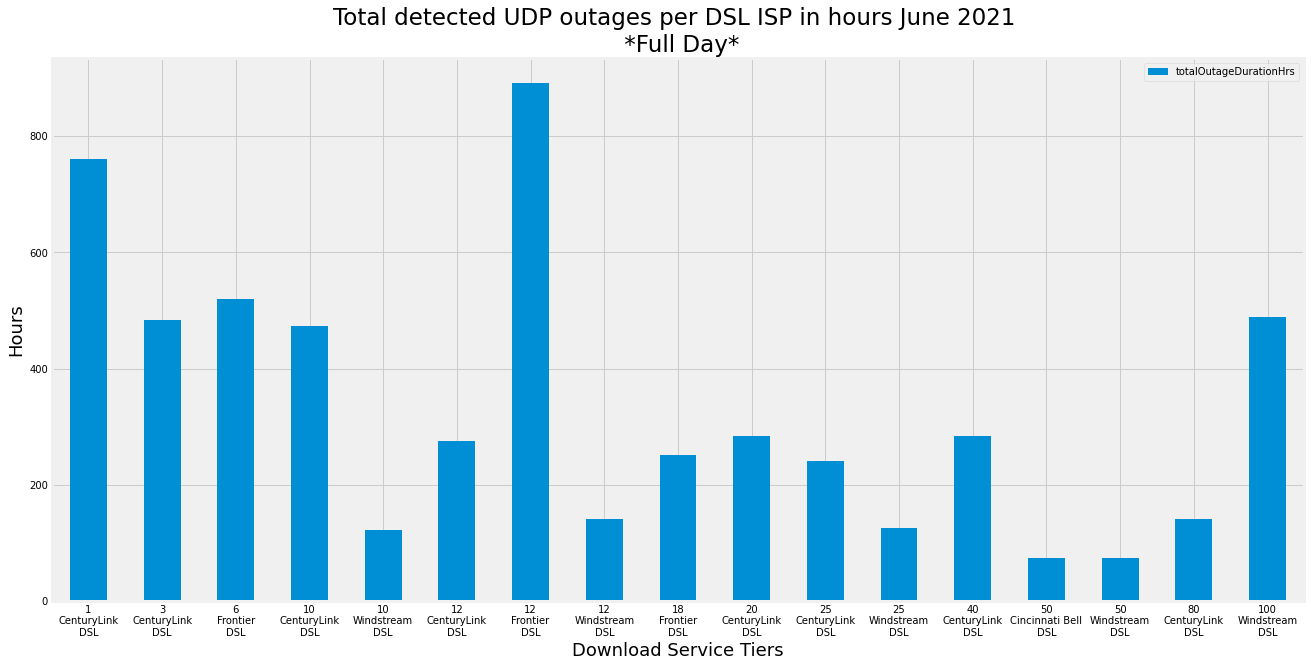

In [18]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'DSL']



ax = chartData.plot(x = "ispTech", y = [ 'totalOutageDurationHrs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Hours', fontsize=18)
ax.set_title('Total detected UDP outages per DSL ISP in hours June 2021 \n *Full Day*', fontsize=23)



plt.show()

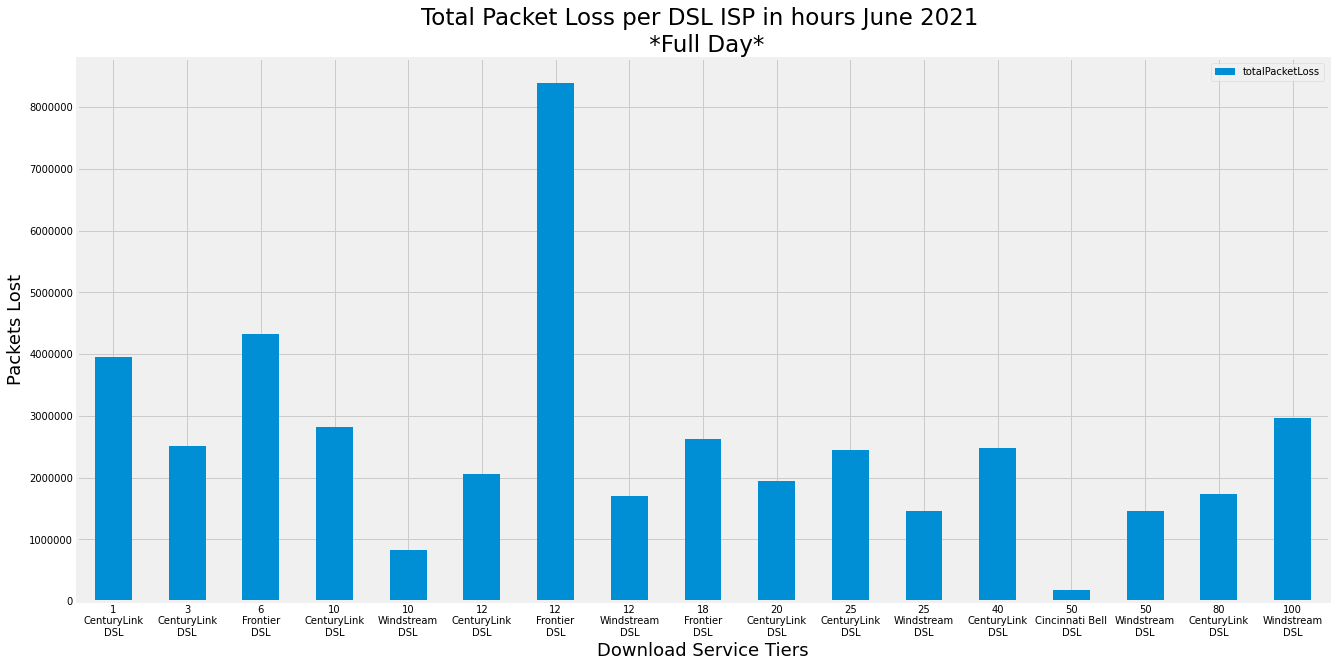

In [19]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'DSL']



ax = chartData.plot(x = "ispTech", y = [ 'totalPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Packets Lost', fontsize=18)
ax.set_title('Total Packet Loss per DSL ISP in hours June 2021 \n *Full Day*', fontsize=23)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

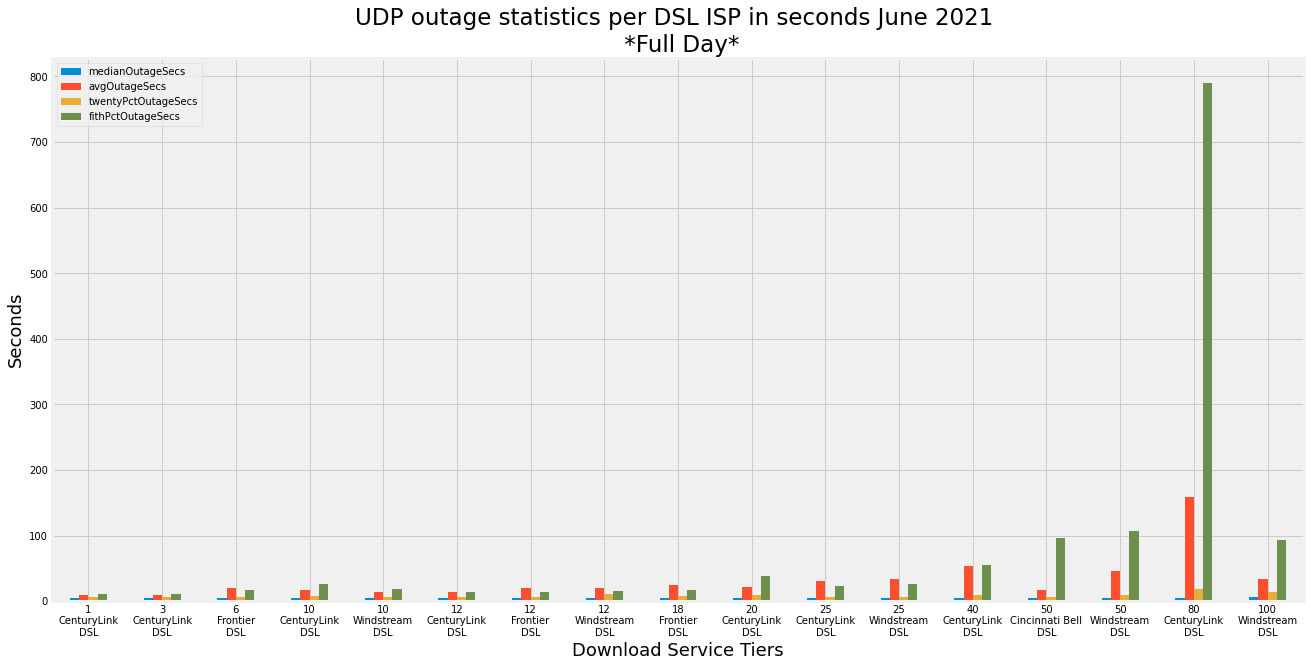

In [20]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'DSL']

ax = chartData.plot(x = "ispTech", y = [ 'medianOutageSecs','avgOutageSecs', 'twentyPctOutageSecs','fithPctOutageSecs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('UDP outage statistics per DSL ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

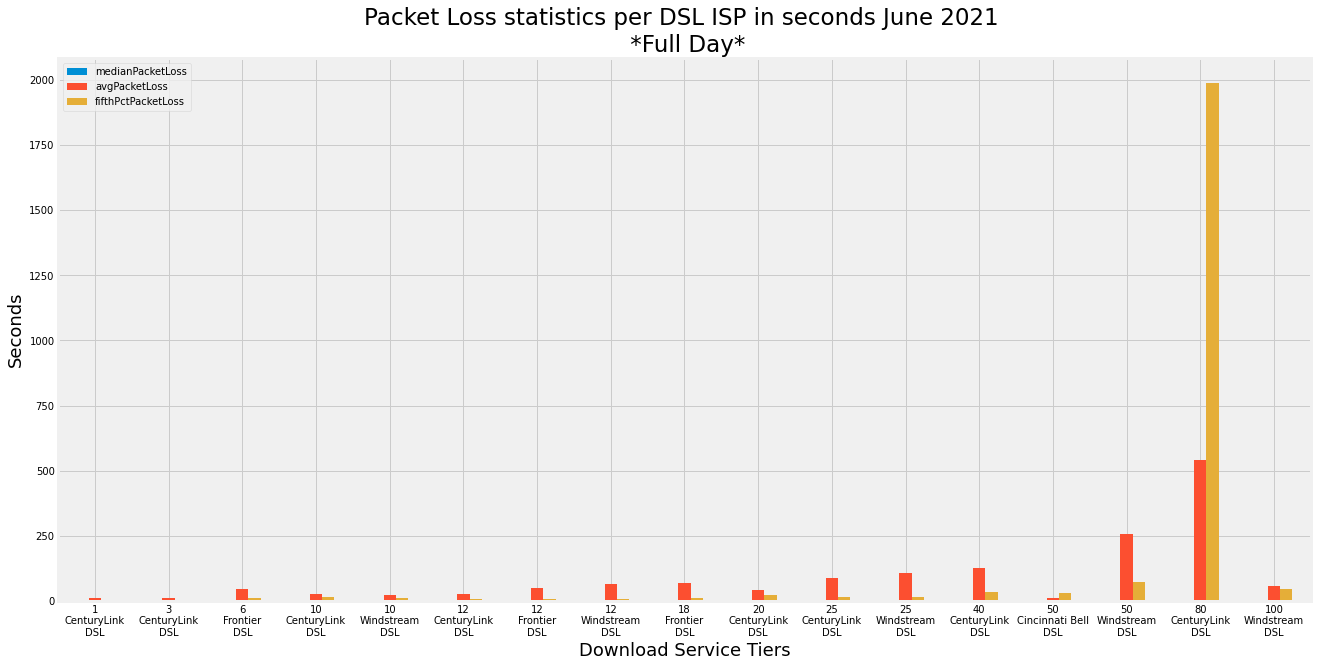

In [21]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'DSL']

ax = chartData.plot(x = "ispTech", y = [ 'medianPacketLoss','avgPacketLoss', 'fifthPctPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('Packet Loss statistics per DSL ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

<h3> Cable

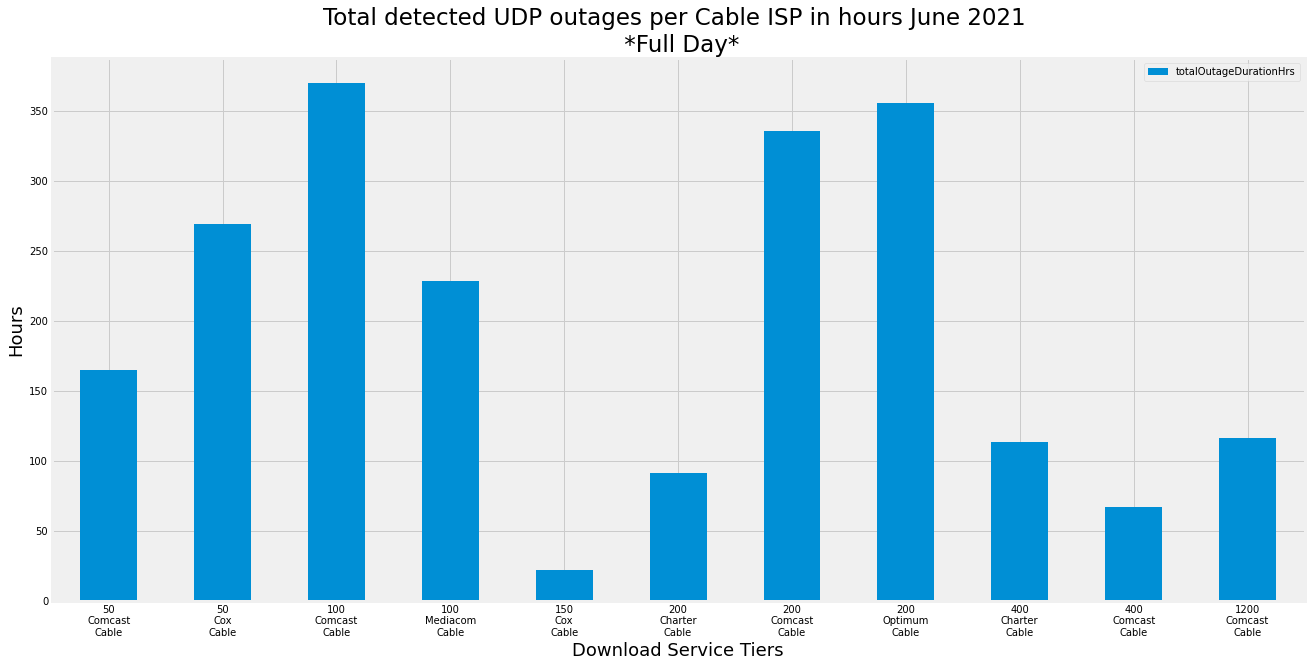

In [22]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Cable']



ax = chartData.plot(x = "ispTech", y = [ 'totalOutageDurationHrs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Hours', fontsize=18)
ax.set_title('Total detected UDP outages per Cable ISP in hours June 2021 \n *Full Day*', fontsize=23)



plt.show()

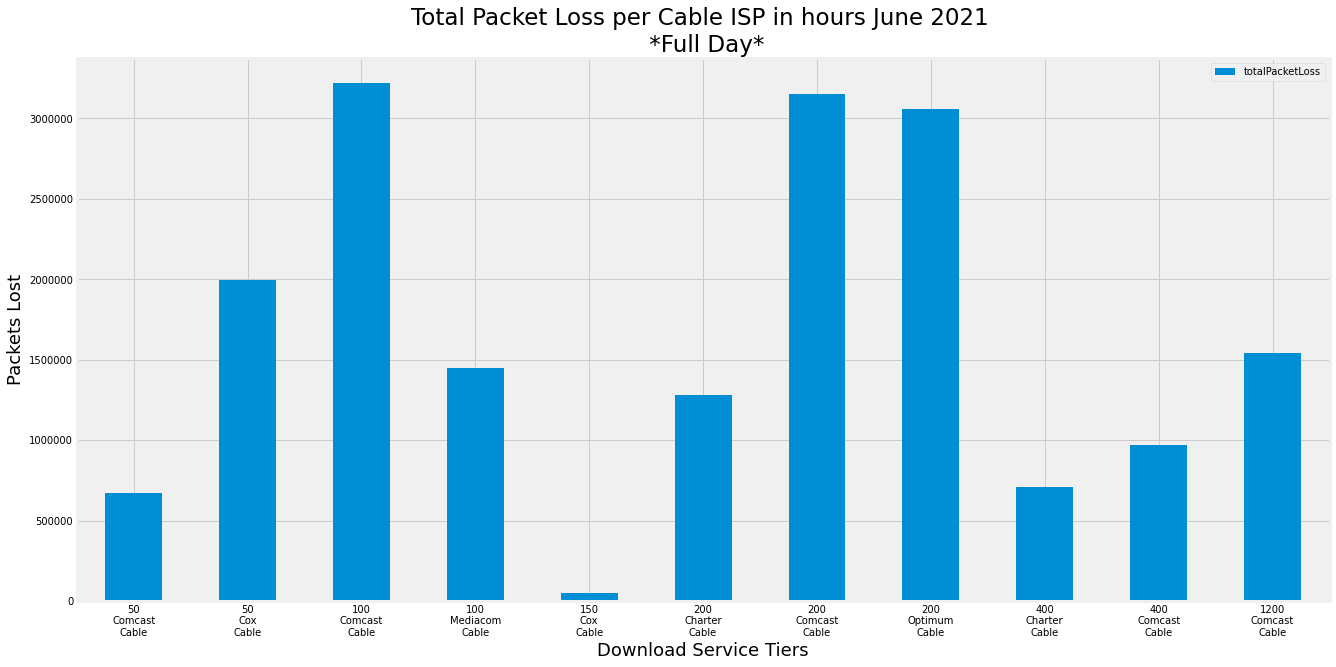

In [23]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Cable']



ax = chartData.plot(x = "ispTech", y = [ 'totalPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Packets Lost', fontsize=18)
ax.set_title('Total Packet Loss per Cable ISP in hours June 2021 \n *Full Day*', fontsize=23)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

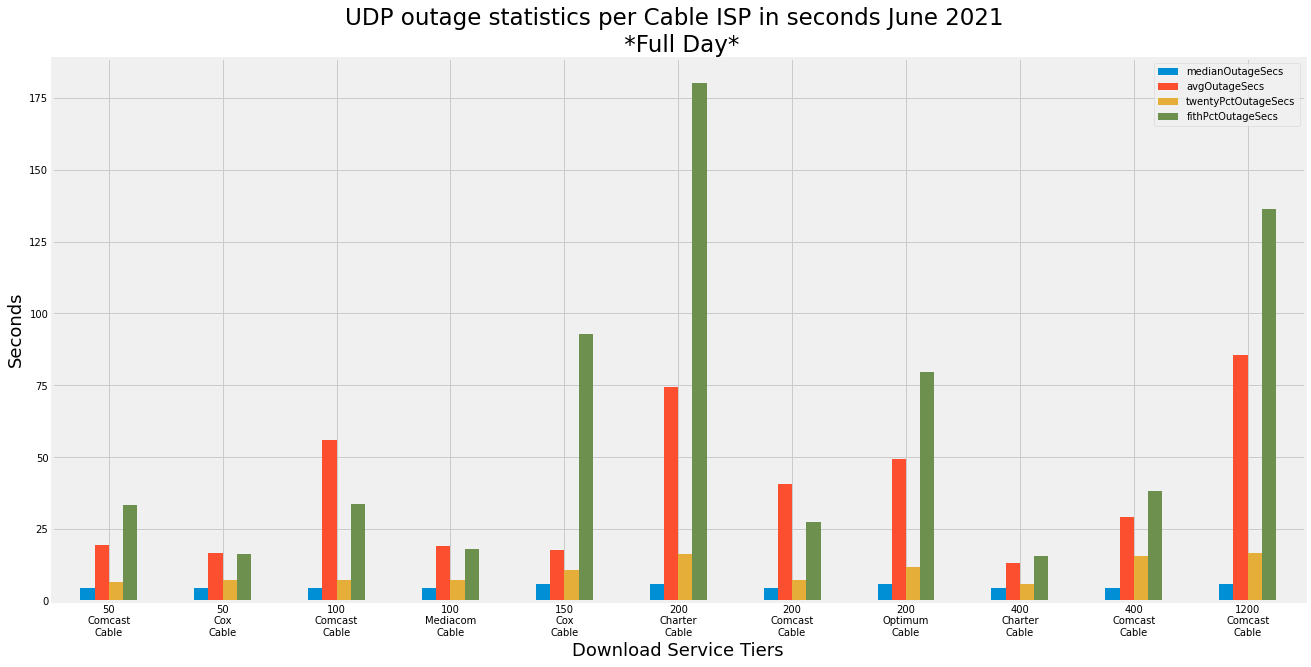

In [24]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Cable']

ax = chartData.plot(x = "ispTech", y = [ 'medianOutageSecs','avgOutageSecs', 'twentyPctOutageSecs','fithPctOutageSecs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('UDP outage statistics per Cable ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

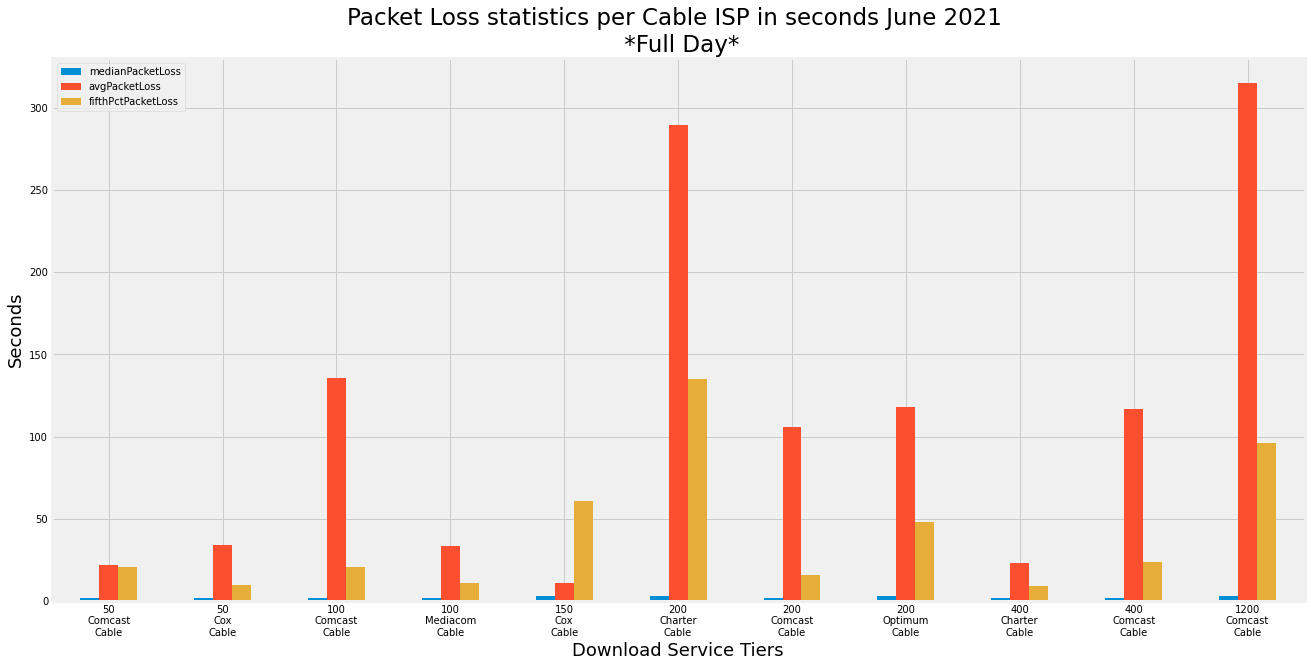

In [25]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Cable']

ax = chartData.plot(x = "ispTech", y = [ 'medianPacketLoss','avgPacketLoss', 'fifthPctPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('Packet Loss statistics per Cable ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

<h3> Fiber

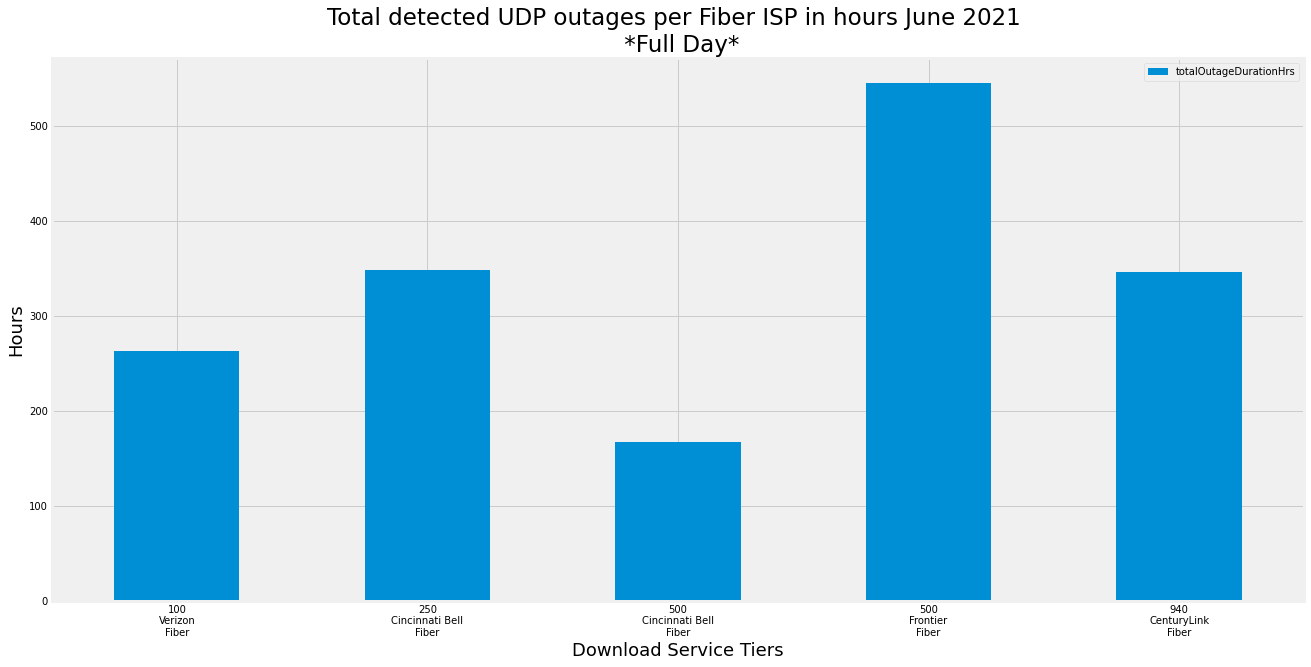

In [26]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Fiber']



ax = chartData.plot(x = "ispTech", y = [ 'totalOutageDurationHrs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Hours', fontsize=18)
ax.set_title('Total detected UDP outages per Fiber ISP in hours June 2021 \n *Full Day*', fontsize=23)



plt.show()

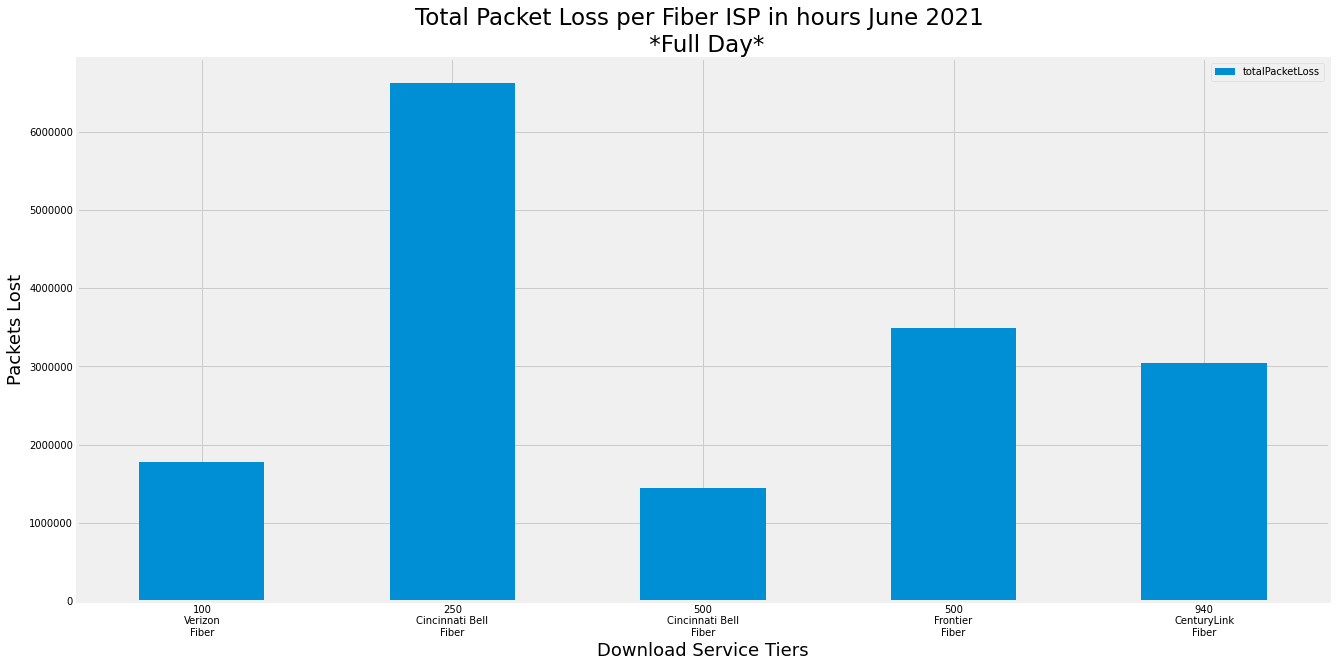

In [27]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Fiber']



ax = chartData.plot(x = "ispTech", y = [ 'totalPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Packets Lost', fontsize=18)
ax.set_title('Total Packet Loss per Fiber ISP in hours June 2021 \n *Full Day*', fontsize=23)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

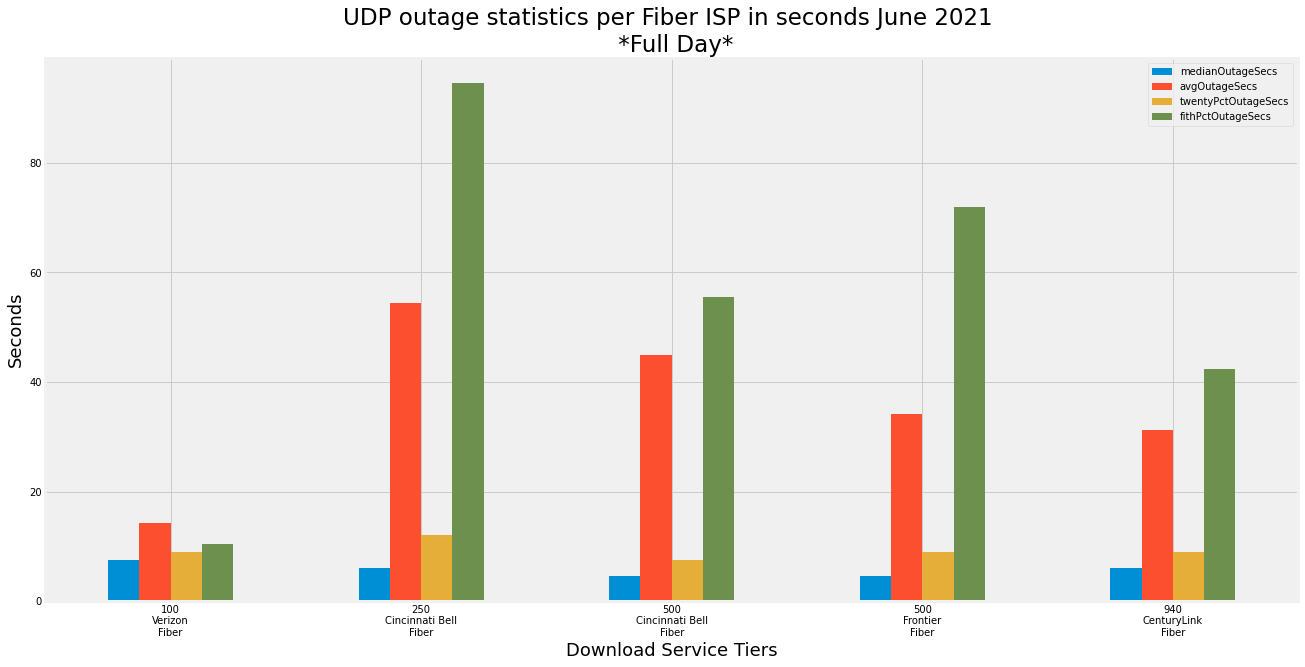

In [28]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Fiber']

ax = chartData.plot(x = "ispTech", y = [ 'medianOutageSecs','avgOutageSecs', 'twentyPctOutageSecs','fithPctOutageSecs'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('UDP outage statistics per Fiber ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

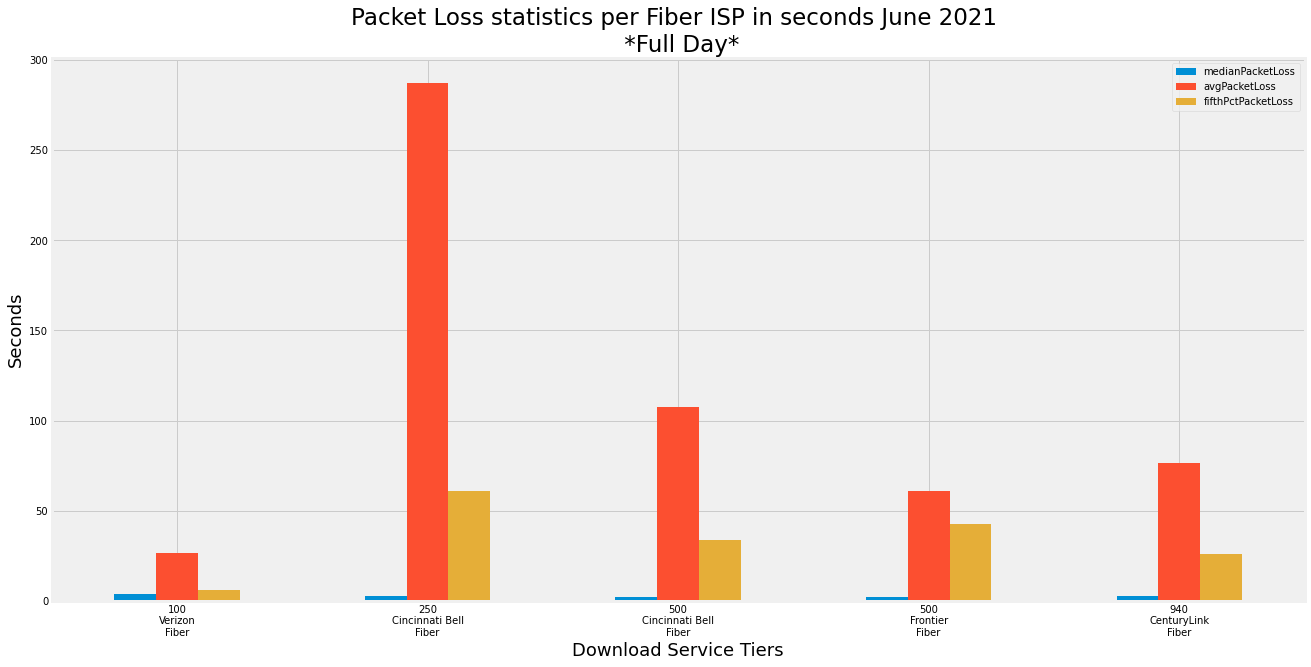

In [29]:
chartData = pd.DataFrame()
chartData = rawMBAJun21[rawMBAJun21['tech'] == 'Fiber']

ax = chartData.plot(x = "ispTech", y = [ 'medianPacketLoss','avgPacketLoss', 'fifthPctPacketLoss'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers', fontsize=18)
ax.set_ylabel('Seconds', fontsize=18)
ax.set_title('Packet Loss statistics per Fiber ISP in seconds June 2021 \n *Full Day*', fontsize=23)



plt.show()

<h3> Specific Tier Analysis 

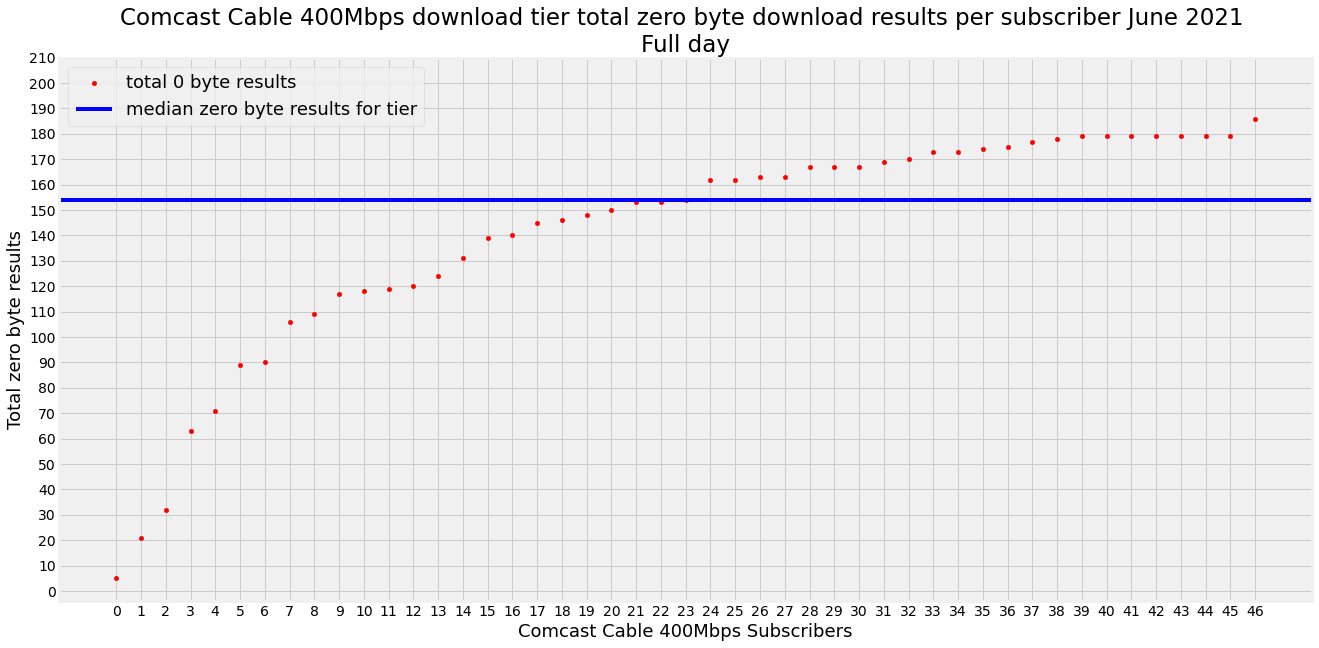

In [30]:
chartData = pd.DataFrame()
chartData['0ByteResults'] = comcast400Jun21[('0ByteResults', 'count')]
chartData = chartData.sort_values(by='0ByteResults' )

x=[]
for i in range(len(chartData)):
    x.append(i)
chartData['Subscribers'] = x


ax1 = chartData.plot(x = 'Subscribers' ,y = '0ByteResults',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r", label = "total 0 byte results")


median = chartData['0ByteResults'].median()
plt.yticks(np.arange(0, 220, 10))
plt.xticks(np.arange(0, len(chartData), 1))
plt.axhline(y = median, color = 'blue', linestyle = '-', label = "median zero byte results for tier")

ax1.set_xlabel('Comcast Cable 400Mbps Subscribers', fontsize=18)
ax1.set_ylabel('Total zero byte results', fontsize=18)
ax1.set_title('Comcast Cable 400Mbps download tier total zero byte download results per subscriber June 2021 \nFull day', fontsize=23)

plt.legend( fontsize = 18)


In [31]:
print("Comcast 400 download tier zero byte results: \n", chartData)

Comcast 400 download tier zero byte results: 
           0ByteResults  Subscribers
unitID                             
676048             5.0            0
25657749          21.0            1
36509073          32.0            2
243240            63.0            3
24525589          71.0            4
846955            89.0            5
38658861          90.0            6
950376           106.0            7
38713393         109.0            8
38713709         117.0            9
25657853         118.0           10
216804           119.0           11
39774597         120.0           12
3782381          124.0           13
1006746          131.0           14
3603097          139.0           15
38713673         140.0           16
24733197         145.0           17
38713277         146.0           18
798486           148.0           19
40468065         150.0           20
1006754          153.0           21
38659021         153.0           22
3693249          154.0           23
39287725         

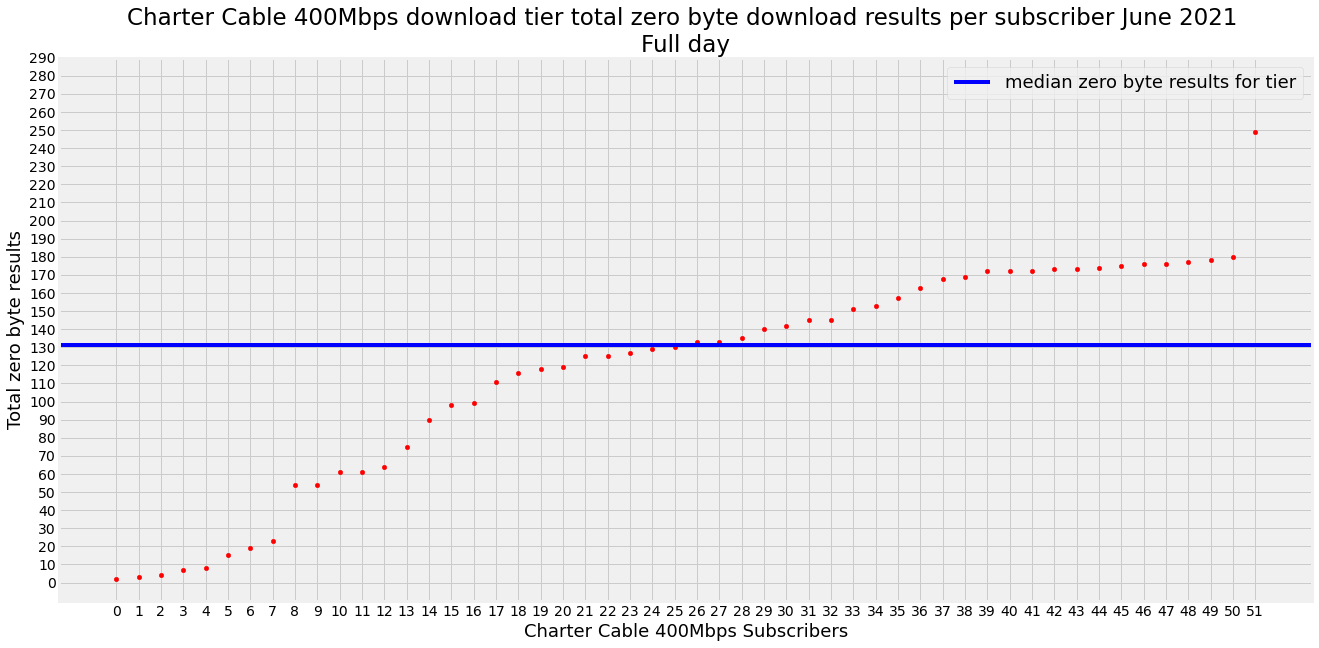

In [32]:
zeroByteResults = charter400Jun21[('0ByteResults', 'count')]
zeroByteResults = zeroByteResults.sort_values()
zeroByteResults = zeroByteResults.to_frame().reset_index()

x=[]
for i in range(len(zeroByteResults)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['0ByteResults'] = zeroByteResults[('0ByteResults','count')]
chartData['Subscribers'] = x


ax = chartData.plot(x = 'Subscribers' ,y = '0ByteResults',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r")

median = chartData['0ByteResults'].median()
plt.yticks(np.arange(0, 300, 10))
plt.xticks(np.arange(0, len(zeroByteResults), 1))
plt.axhline(y = median, color = 'blue', linestyle = '-', label = "median zero byte results for tier")

ax.set_xlabel('Charter Cable 400Mbps Subscribers', fontsize=18)
ax.set_ylabel('Total zero byte results', fontsize=18)
ax.set_title('Charter Cable 400Mbps download tier total zero byte download results per subscriber June 2021 \nFull day', fontsize=23)

plt.legend( fontsize = 18)

In [33]:
print("Charter 400 download tier zero byte results: \n", chartData)

Charter 400 download tier zero byte results: 
     0ByteResults  Subscribers
0            2.0            0
1            3.0            1
2            4.0            2
3            7.0            3
4            8.0            4
5           15.0            5
6           19.0            6
7           23.0            7
8           54.0            8
9           54.0            9
10          61.0           10
11          61.0           11
12          64.0           12
13          75.0           13
14          90.0           14
15          98.0           15
16          99.0           16
17         111.0           17
18         116.0           18
19         118.0           19
20         119.0           20
21         125.0           21
22         125.0           22
23         127.0           23
24         129.0           24
25         130.0           25
26         133.0           26
27         133.0           27
28         135.0           28
29         140.0           29
30         142.0       

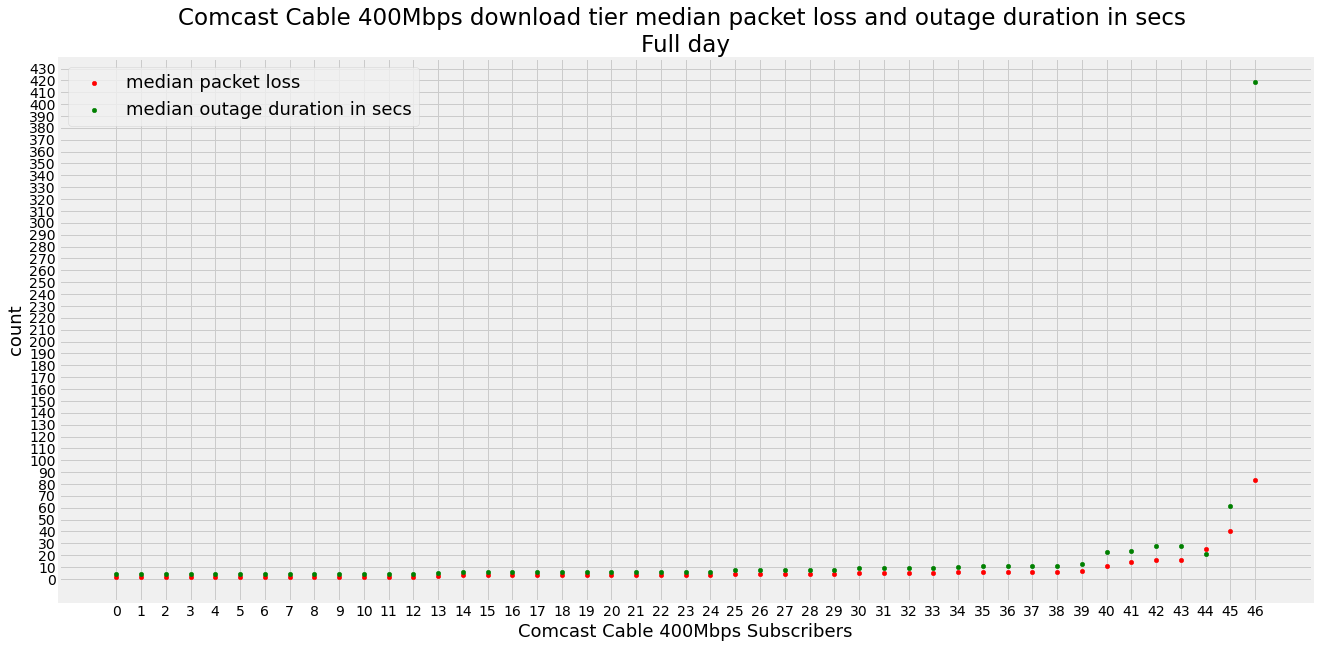

In [34]:
chartData = pd.DataFrame()
chartData['medianPacketLoss'] = comcast400Jun21[( 'packetsLost',   '50%')]
chartData = chartData.sort_values(by='medianPacketLoss' )
chartData['medianOutageDurationSecs'] = comcast400Jun21[(  'durationMs',   '50%')]/1000

x=[]
for i in range(len(chartData)):
    x.append(i)
chartData['Subscribers'] = x


ax1 = chartData.plot(x = 'Subscribers' ,y = 'medianPacketLoss',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r", label = "median packet loss")

ax2 = chartData.plot(kind='scatter', x='Subscribers', y='medianOutageDurationSecs', color='g',label = 'median outage duration in secs', ax=ax1)    

plt.yticks(np.arange(0, chartData['medianOutageDurationSecs'].max()+20, 10))
plt.xticks(np.arange(0, len(chartData), 1))
# plt.axhline(y = median, color = 'blue', linestyle = '-', label = "median zero byte results for tier")


ax1.set_xlabel('Comcast Cable 400Mbps Subscribers', fontsize=18)
ax1.set_ylabel('count', fontsize=18)
ax1.set_title('Comcast Cable 400Mbps download tier median packet loss and outage duration in secs \nFull day', fontsize=23)
plt.legend( fontsize = 18)


In [35]:
print("Comcast 400 download tier table: \n", chartData)

Comcast 400 download tier table: 
           medianPacketLoss  medianOutageDurationSecs  Subscribers
unitID                                                           
216804                 2.0                  4.501899            0
3942085                2.0                  4.500706            1
1010060                2.0                  4.501475            2
1006754                2.0                  4.500404            3
3953001                2.0                  4.533661            4
1006742                2.0                  4.508883            5
24525589               2.0                  4.511205            6
1006724                2.0                  4.504357            7
24733197               2.0                  4.500247            8
3603097                2.0                  4.509502            9
25657853               2.0                  4.502200           10
36509073               2.0                  4.502359           11
38658881               2.0               

<h3> Same chart as above excluding outlier

Text(0.5, 1.0, 'Comcast Cable 400Mbps download tier median packet loss and outage duration in secs \nFull day without outlier')

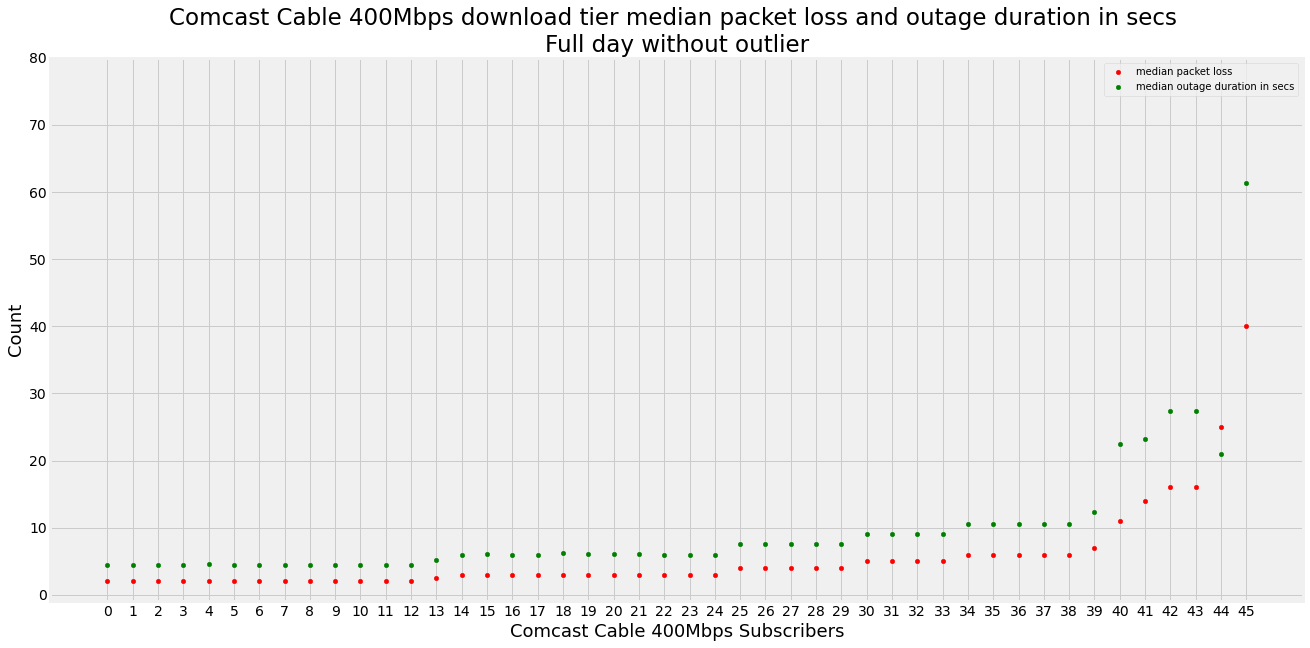

In [36]:
   
chartData = pd.DataFrame()
chartData['medianPacketLoss'] = comcast400Jun21[( 'packetsLost',   '50%')]
chartData = chartData.sort_values(by='medianPacketLoss' )
chartData['medianOutageDurationSecs'] = comcast400Jun21[(  'durationMs',   '50%')]/1000

chartData.drop(chartData.tail(1).index,inplace=True)

x=[]
for i in range(len(chartData)):
    x.append(i)
chartData['Subscribers'] = x


ax1 = chartData.plot(x = 'Subscribers' ,y = 'medianPacketLoss',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r", label = "median packet loss")

ax2 = chartData.plot(kind='scatter', x='Subscribers', y='medianOutageDurationSecs', color='g',label = 'median outage duration in secs', ax=ax1)    

plt.yticks(np.arange(0, chartData['medianOutageDurationSecs'].max()+20, 10))
plt.xticks(np.arange(0, len(chartData), 1))

ax1.set_xlabel('Comcast Cable 400Mbps Subscribers', fontsize=18)
ax1.set_ylabel('Count', fontsize=18)
ax1.set_title('Comcast Cable 400Mbps download tier median packet loss and outage duration in secs \nFull day without outlier', fontsize=23)



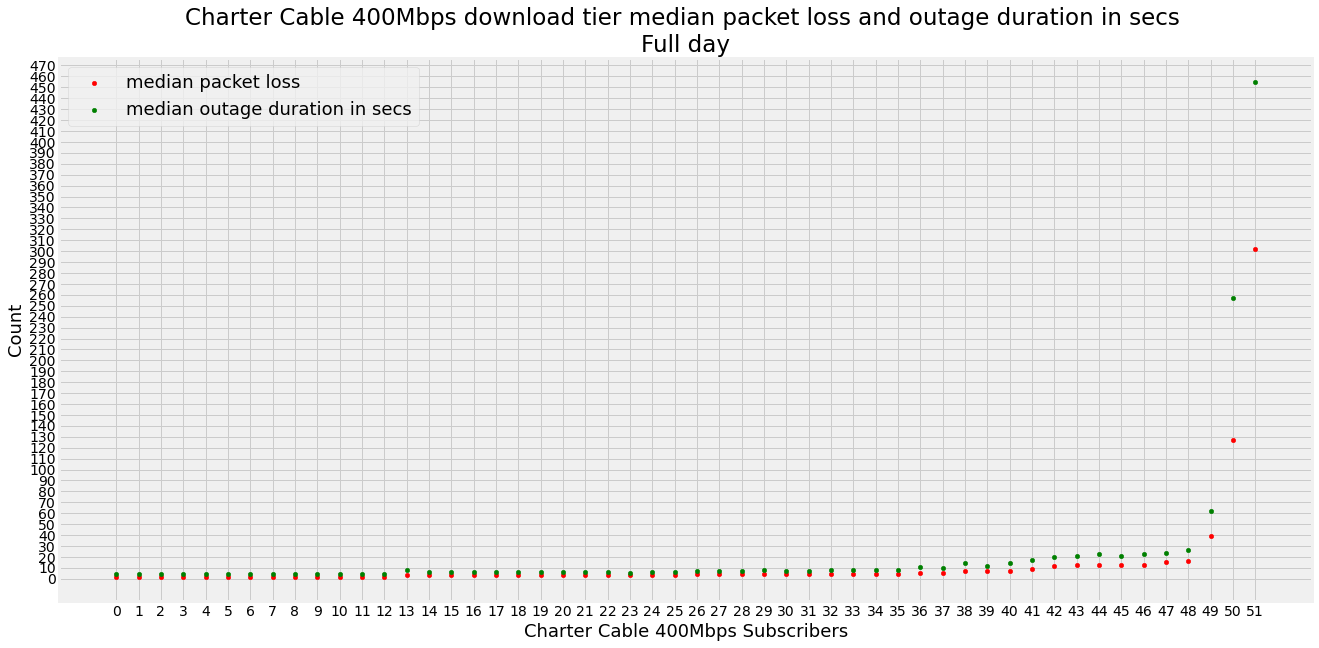

In [37]:
   
chartData = pd.DataFrame()
chartData['medianPacketLoss'] = charter400Jun21[( 'packetsLost',   '50%')]
chartData = chartData.sort_values(by='medianPacketLoss' )
chartData['medianOutageDurationSecs'] = charter400Jun21[(  'durationMs',   '50%')]/1000

x=[]
for i in range(len(chartData)):
    x.append(i)
chartData['Subscribers'] = x


ax1 = chartData.plot(x = 'Subscribers' ,y = 'medianPacketLoss',  kind = 'scatter',
                   fontsize = 14, rot = 0, figsize = (20,10), grid = True, color="r", label = "median packet loss")

ax2 = chartData.plot(kind='scatter', x='Subscribers', y='medianOutageDurationSecs', color='g',label = 'median outage duration in secs', ax=ax1)    

plt.yticks(np.arange(0, chartData['medianOutageDurationSecs'].max()+20, 10))
plt.xticks(np.arange(0, len(chartData), 1))

ax1.set_xlabel('Charter Cable 400Mbps Subscribers', fontsize=18)
ax1.set_ylabel('Count', fontsize=18)
ax1.set_title('Charter Cable 400Mbps download tier median packet loss and outage duration in secs \nFull day', fontsize=23)
plt.legend( fontsize = 18)



In [38]:
print("Charter 400 download tier table: \n", chartData)

Charter 400 download tier table: 
           medianPacketLoss  medianOutageDurationSecs  Subscribers
unitID                                                           
25619409               2.0                  4.508068            0
25886793               2.0                  4.549015            1
25658157               2.0                  4.500590            2
25886949               2.0                  4.510158            3
24806785               2.0                  4.514301            4
24806757               2.0                  4.506388            5
4803393                2.0                  4.504715            6
25887001               2.0                  4.509730            7
25886481               2.0                  4.507559            8
3798985                2.0                  4.505081            9
25886545               2.0                  4.746290           10
39877137               2.0                  4.510804           11
26490609               2.0               